In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd, seaborn as sns
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers.merge import concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from textblob import TextBlob
from tqdm import tqdm
from matplotlib import pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
embed_file1 = os.path.join('.', 'Glove', 'glove.6B.200d.txt')
embed_file2 = os.path.join('.', 'fasttext', 'wiki-news-300d-1M.vec')
train_file = os.path.join('.', 'train.csv')
test_file = os.path.join('.', 'test.csv')

In [3]:
embed_size1 = 200 # how big is each word vector
embed_size2 = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 400 # max number of words in a comment to use

In [4]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

(array([47650., 34014., 20458., 13556.,  8554.,  6060.,  4331.,  3109.,
         2399.,  1863.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <a list of 10 Patch objects>)

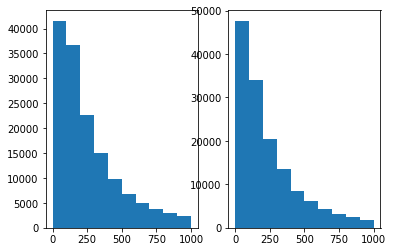

In [18]:
plt.subplot(121)
plt.hist([len(i) for i in list(list_sentences_train)], range=(0,1000))
plt.subplot(122)
plt.hist([len(i) for i in list(list_sentences_test)], range=(0,1000))

In [7]:
from nltk.corpus import stopwords
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train)+list(list_sentences_test))

list_tokenized_train = []
for text in tqdm(list_sentences_train):
    words = text_to_word_sequence(text)
    #seq = [tokenizer.word_index.get(w) for w in words]
    seq = []
    for w in words:
        if w not in list(stopwords.words('english')):
            ind = tokenizer.word_index.get(w)
            if ind<max_features:
                seq.append(ind)
    list_tokenized_train.append(seq)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
    
list_tokenized_test = []
for text in tqdm(list_sentences_test):
    words = text_to_word_sequence(text)
    seq = []
    for w in words:
        if w not in list(stopwords.words('english')):
            ind = tokenizer.word_index.get(w)
            if ind<max_features:
                seq.append(ind)
    list_tokenized_test.append(seq)

X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

100%|██████████████████████████████████| 153164/153164 [46:06<00:00, 55.36it/s]


In [8]:
np.save('train_x.npy', X_t)
np.save('test_x.npy', X_te)

In [5]:
X_t = np.load('train_x.npy')
X_te = np.load('test_x.npy')

In [22]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index1 = dict(get_coefs(*o.strip().split()) for o in open(embed_file1, encoding='utf-8'))
embeddings_index2 = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embed_file2, encoding = 'utf-8'))

In [23]:
all_embs1 = np.hstack(embeddings_index1.values())
emb_mean1,emb_std1 = all_embs1.mean(), all_embs1.std()
emb_mean1,emb_std1

(-0.008671864, 0.38186216)

In [24]:
all_embs2 = np.hstack(embeddings_index2.values())
emb_mean2,emb_std2 = all_embs2.mean(), all_embs2.std()
emb_mean2,emb_std2

(-0.0033459952, 0.1112124)

In [107]:
counts = list(tokenizer.word_counts.values())
print(len(counts), counts[:9])
#plt.hist(counts, range=(0,400))
print (list(tokenizer.word_index.items())[:9])
print (list(tokenizer.word_counts.items())[:9])
w,i = list(tokenizer.word_index.items())[111]
print (w, tokenizer.word_counts.get('fuck'))
print(tokenizer.word_docs.get('fuck'))

394787 [3095, 31804, 917801, 16189, 17181, 12228, 78385, 3172, 320]
[('the', 1), ('to', 2), ('of', 3), ('a', 4), ('and', 5), ('you', 6), ('i', 7), ('is', 8), ('that', 9)]
[('explanation', 3095), ('why', 31804), ('the', 917801), ('edits', 16189), ('made', 17181), ('under', 12228), ('my', 78385), ('username', 3172), ('hardcore', 320)]
these 36996
7626


In [25]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix1 = np.random.normal(emb_mean1, emb_std1, (nb_words, embed_size1))
embedding_matrix2 = np.random.normal(emb_mean2, emb_std2, (nb_words, embed_size2))

for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector1 = embeddings_index1.get(word)
    if embedding_vector1 is not None: embedding_matrix1[i] = embedding_vector1
        
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector2 = embeddings_index2.get(word)
    if embedding_vector2 is not None: embedding_matrix2[i] = embedding_vector2

In [26]:
import gc
del embeddings_index1, embeddings_index2, all_embs1, all_embs2, word_index, tokenizer
gc.collect()

305

In [20]:
from keras import backend as K
K.clear_session()

In [10]:
inp = Input(shape=(maxlen,))
x1 = Embedding(max_features, embed_size1, weights=[embedding_matrix1], trainable = False)(inp)
x2 = Embedding(max_features, embed_size2, weights=[embedding_matrix2], trainable = False)(inp)
x = concatenate([x1,x2])
x = SpatialDropout1D(0.4)(x)

x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x, h, _ = Bidirectional(GRU(64, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1))(x)
gmp = GlobalMaxPooling1D()(x)
gap = GlobalAveragePooling1D()(x)
conc = concatenate([h, gmp, gap])
x = Dense(64, activation="relu")(conc)
x = Dropout(0.3)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
adam = optimizers.Adam(lr=0.0001, clipnorm=6.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'embedding_matrix1' is not defined

In [7]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.95, random_state=13)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
adam = optimizers.Adam(lr=0.00001, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
cp = ModelCheckpoint(filepath="my_model11.h5", save_best_only=True)
es = EarlyStopping(patience=1)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit(X_tra, y_tra, batch_size = 32, epochs=2, validation_data=(X_val, y_val), callbacks=[cp, es, rp, RocAuc])

Train on 151592 samples, validate on 7979 samples
Epoch 1/2


  6176/151592 [>.............................] - ETA: 8:08:43 - loss: 0.0370 - acc: 0.97 - ETA: 5:03:16 - loss: 0.0320 - acc: 0.98 - ETA: 4:00:11 - loss: 0.0303 - acc: 0.98 - ETA: 3:30:08 - loss: 0.0378 - acc: 0.98 - ETA: 3:10:33 - loss: 0.0334 - acc: 0.98 - ETA: 2:58:26 - loss: 0.0301 - acc: 0.98 - ETA: 2:49:03 - loss: 0.0270 - acc: 0.98 - ETA: 2:42:10 - loss: 0.0255 - acc: 0.98 - ETA: 2:36:56 - loss: 0.0272 - acc: 0.98 - ETA: 2:32:40 - loss: 0.0263 - acc: 0.98 - ETA: 2:28:44 - loss: 0.0292 - acc: 0.98 - ETA: 2:25:34 - loss: 0.0300 - acc: 0.98 - ETA: 2:23:09 - loss: 0.0323 - acc: 0.98 - ETA: 2:21:01 - loss: 0.0323 - acc: 0.98 - ETA: 2:19:17 - loss: 0.0358 - acc: 0.98 - ETA: 2:17:38 - loss: 0.0343 - acc: 0.98 - ETA: 2:16:35 - loss: 0.0353 - acc: 0.98 - ETA: 2:16:06 - loss: 0.0359 - acc: 0.98 - ETA: 2:15:39 - loss: 0.0365 - acc: 0.98 - ETA: 2:14:52 - loss: 0.0385 - acc: 0.98 - ETA: 2:13:51 - loss: 0.0379 - acc: 0.98 - ETA: 2:12:57 - loss: 0.0383 - acc: 0.98 - ETA: 2:12:12 - loss: 0.0372

 12384/151592 [=>............................] - ETA: 2:12:00 - loss: 0.0389 - acc: 0.98 - ETA: 2:12:07 - loss: 0.0389 - acc: 0.98 - ETA: 2:12:15 - loss: 0.0392 - acc: 0.98 - ETA: 2:12:24 - loss: 0.0394 - acc: 0.98 - ETA: 2:12:31 - loss: 0.0394 - acc: 0.98 - ETA: 2:12:40 - loss: 0.0393 - acc: 0.98 - ETA: 2:12:48 - loss: 0.0392 - acc: 0.98 - ETA: 2:12:57 - loss: 0.0391 - acc: 0.98 - ETA: 2:13:07 - loss: 0.0393 - acc: 0.98 - ETA: 2:13:19 - loss: 0.0393 - acc: 0.98 - ETA: 2:13:30 - loss: 0.0393 - acc: 0.98 - ETA: 2:13:39 - loss: 0.0392 - acc: 0.98 - ETA: 2:13:48 - loss: 0.0393 - acc: 0.98 - ETA: 2:13:56 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:05 - loss: 0.0391 - acc: 0.98 - ETA: 2:14:15 - loss: 0.0391 - acc: 0.98 - ETA: 2:14:24 - loss: 0.0391 - acc: 0.98 - ETA: 2:14:32 - loss: 0.0390 - acc: 0.98 - ETA: 2:14:42 - loss: 0.0393 - acc: 0.98 - ETA: 2:14:51 - loss: 0.0392 - acc: 0.98 - ETA: 2:15:01 - loss: 0.0396 - acc: 0.98 - ETA: 2:15:12 - loss: 0.0398 - acc: 0.98 - ETA: 2:15:22 - loss: 0.0398

 18592/151592 [==>...........................] - ETA: 2:36:32 - loss: 0.0406 - acc: 0.98 - ETA: 2:36:37 - loss: 0.0406 - acc: 0.98 - ETA: 2:36:39 - loss: 0.0405 - acc: 0.98 - ETA: 2:36:41 - loss: 0.0405 - acc: 0.98 - ETA: 2:36:44 - loss: 0.0404 - acc: 0.98 - ETA: 2:36:51 - loss: 0.0404 - acc: 0.98 - ETA: 2:36:53 - loss: 0.0404 - acc: 0.98 - ETA: 2:36:55 - loss: 0.0404 - acc: 0.98 - ETA: 2:36:59 - loss: 0.0406 - acc: 0.98 - ETA: 2:37:01 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:03 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:05 - loss: 0.0406 - acc: 0.98 - ETA: 2:37:08 - loss: 0.0406 - acc: 0.98 - ETA: 2:37:09 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:12 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:14 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:17 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:20 - loss: 0.0404 - acc: 0.98 - ETA: 2:37:21 - loss: 0.0404 - acc: 0.98 - ETA: 2:37:23 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:25 - loss: 0.0405 - acc: 0.98 - ETA: 2:37:27 - loss: 0.0404 - acc: 0.98 - ETA: 2:37:29 - loss: 0.0405

 24800/151592 [===>..........................] - ETA: 2:41:08 - loss: 0.0404 - acc: 0.98 - ETA: 2:41:08 - loss: 0.0404 - acc: 0.98 - ETA: 2:41:09 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:11 - loss: 0.0404 - acc: 0.98 - ETA: 2:41:11 - loss: 0.0405 - acc: 0.98 - ETA: 2:41:11 - loss: 0.0405 - acc: 0.98 - ETA: 2:41:10 - loss: 0.0405 - acc: 0.98 - ETA: 2:41:09 - loss: 0.0404 - acc: 0.98 - ETA: 2:41:08 - loss: 0.0404 - acc: 0.98 - ETA: 2:41:08 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:07 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:07 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:08 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:09 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:09 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:10 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:12 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:11 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:12 - loss: 0.0402 - acc: 0.98 - ETA: 2:41:12 - loss: 0.0402 - acc: 0.98 - ETA: 2:41:11 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:10 - loss: 0.0403 - acc: 0.98 - ETA: 2:41:09 - loss: 0.0402

 31008/151592 [=====>........................] - ETA: 2:38:31 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:30 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:29 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:28 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:27 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:25 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:24 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:23 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:21 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:20 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:19 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:19 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:18 - loss: 0.0397 - acc: 0.98 - ETA: 2:38:18 - loss: 0.0397 - acc: 0.98 - ETA: 2:38:17 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:18 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:17 - loss: 0.0396 - acc: 0.98 - ETA: 2:38:16 - loss: 0.0397 - acc: 0.98 - ETA: 2:38:17 - loss: 0.0397 - acc: 0.98 - ETA: 2:38:16 - loss: 0.0397 - acc: 0.98 - ETA: 2:38:16 - loss: 0.0397 - acc: 0.98 - ETA: 2:38:15 - loss: 0.0398 - acc: 0.98 - ETA: 2:38:14 - loss: 0.0398

 37216/151592 [======>.......................] - ETA: 2:34:29 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:28 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:26 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:24 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:22 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:21 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:19 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:18 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:16 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:15 - loss: 0.0396 - acc: 0.98 - ETA: 2:34:13 - loss: 0.0396 - acc: 0.98 - ETA: 2:34:11 - loss: 0.0396 - acc: 0.98 - ETA: 2:34:09 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:07 - loss: 0.0397 - acc: 0.98 - ETA: 2:34:05 - loss: 0.0396 - acc: 0.98 - ETA: 2:34:03 - loss: 0.0396 - acc: 0.98 - ETA: 2:34:01 - loss: 0.0396 - acc: 0.98 - ETA: 2:33:59 - loss: 0.0396 - acc: 0.98 - ETA: 2:33:57 - loss: 0.0396 - acc: 0.98 - ETA: 2:33:55 - loss: 0.0396 - acc: 0.98 - ETA: 2:33:54 - loss: 0.0396 - acc: 0.98 - ETA: 2:33:52 - loss: 0.0396 - acc: 0.98 - ETA: 2:33:50 - loss: 0.0396

 43424/151592 [=======>......................] - ETA: 2:28:38 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:36 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:34 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:32 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:30 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:28 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:26 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:24 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:22 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:20 - loss: 0.0391 - acc: 0.98 - ETA: 2:28:19 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:17 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:15 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:13 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:12 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:10 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:08 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:07 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:05 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:03 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:01 - loss: 0.0390 - acc: 0.98 - ETA: 2:28:00 - loss: 0.0390 - acc: 0.98 - ETA: 2:27:58 - loss: 0.0390

 49632/151592 [========>.....................] - ETA: 2:22:06 - loss: 0.0389 - acc: 0.98 - ETA: 2:22:03 - loss: 0.0389 - acc: 0.98 - ETA: 2:22:01 - loss: 0.0389 - acc: 0.98 - ETA: 2:21:59 - loss: 0.0389 - acc: 0.98 - ETA: 2:21:57 - loss: 0.0389 - acc: 0.98 - ETA: 2:21:55 - loss: 0.0389 - acc: 0.98 - ETA: 2:21:54 - loss: 0.0389 - acc: 0.98 - ETA: 2:21:52 - loss: 0.0389 - acc: 0.98 - ETA: 2:21:50 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:48 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:45 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:43 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:41 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:40 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:37 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:35 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:33 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:31 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:29 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:27 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:25 - loss: 0.0391 - acc: 0.98 - ETA: 2:21:23 - loss: 0.0390 - acc: 0.98 - ETA: 2:21:21 - loss: 0.0391

 55840/151592 [==========>...................] - ETA: 2:15:30 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:28 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:25 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:23 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:21 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:19 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:16 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:14 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:11 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:09 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:07 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:05 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:02 - loss: 0.0393 - acc: 0.98 - ETA: 2:15:00 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:57 - loss: 0.0393 - acc: 0.98 - ETA: 2:14:55 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:52 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:50 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:47 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:45 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:43 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:40 - loss: 0.0392 - acc: 0.98 - ETA: 2:14:38 - loss: 0.0392

 62048/151592 [===========>..................] - ETA: 2:08:08 - loss: 0.0397 - acc: 0.98 - ETA: 2:08:06 - loss: 0.0397 - acc: 0.98 - ETA: 2:08:03 - loss: 0.0397 - acc: 0.98 - ETA: 2:08:01 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:59 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:56 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:54 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:51 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:49 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:47 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:45 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:42 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:40 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:37 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:35 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:32 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:30 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:28 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:26 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:23 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:21 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:19 - loss: 0.0397 - acc: 0.98 - ETA: 2:07:16 - loss: 0.0397

 68256/151592 [============>.................] - ETA: 2:00:27 - loss: 0.0398 - acc: 0.98 - ETA: 2:00:25 - loss: 0.0398 - acc: 0.98 - ETA: 2:00:22 - loss: 0.0397 - acc: 0.98 - ETA: 2:00:20 - loss: 0.0397 - acc: 0.98 - ETA: 2:00:17 - loss: 0.0397 - acc: 0.98 - ETA: 2:00:14 - loss: 0.0397 - acc: 0.98 - ETA: 2:00:12 - loss: 0.0397 - acc: 0.98 - ETA: 2:00:09 - loss: 0.0397 - acc: 0.98 - ETA: 2:00:07 - loss: 0.0398 - acc: 0.98 - ETA: 2:00:04 - loss: 0.0398 - acc: 0.98 - ETA: 2:00:02 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:59 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:57 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:54 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:52 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:49 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:47 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:44 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:42 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:39 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:36 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:34 - loss: 0.0398 - acc: 0.98 - ETA: 1:59:31 - loss: 0.0398

 74464/151592 [=============>................] - ETA: 1:52:28 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:26 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:24 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:21 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:19 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:16 - loss: 0.0396 - acc: 0.98 - ETA: 1:52:14 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:12 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:09 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:07 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:04 - loss: 0.0397 - acc: 0.98 - ETA: 1:52:02 - loss: 0.0397 - acc: 0.98 - ETA: 1:51:59 - loss: 0.0397 - acc: 0.98 - ETA: 1:51:57 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:54 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:52 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:50 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:48 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:45 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:43 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:41 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:38 - loss: 0.0396 - acc: 0.98 - ETA: 1:51:35 - loss: 0.0396

 80672/151592 [==============>...............] - ETA: 1:44:39 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:36 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:34 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:31 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:28 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:26 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:23 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:21 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:18 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:16 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:13 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:11 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:08 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:06 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:03 - loss: 0.0395 - acc: 0.98 - ETA: 1:44:01 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:58 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:56 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:53 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:50 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:48 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:45 - loss: 0.0395 - acc: 0.98 - ETA: 1:43:43 - loss: 0.0395

 86880/151592 [================>.............] - ETA: 1:36:31 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:29 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:26 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:24 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:21 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:19 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:16 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:14 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:11 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:09 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:06 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:04 - loss: 0.0396 - acc: 0.98 - ETA: 1:36:01 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:59 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:56 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:54 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:51 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:49 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:46 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:43 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:41 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:38 - loss: 0.0396 - acc: 0.98 - ETA: 1:35:36 - loss: 0.0396

 93088/151592 [=================>............] - ETA: 1:28:36 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:34 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:31 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:29 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:26 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:24 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:21 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:19 - loss: 0.0396 - acc: 0.98 - ETA: 1:28:16 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:14 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:11 - loss: 0.0397 - acc: 0.98 - ETA: 1:28:09 - loss: 0.0396 - acc: 0.98 - ETA: 1:28:06 - loss: 0.0396 - acc: 0.98 - ETA: 1:28:04 - loss: 0.0396 - acc: 0.98 - ETA: 1:28:01 - loss: 0.0396 - acc: 0.98 - ETA: 1:27:59 - loss: 0.0396 - acc: 0.98 - ETA: 1:27:56 - loss: 0.0396 - acc: 0.98 - ETA: 1:27:53 - loss: 0.0396 - acc: 0.98 - ETA: 1:27:51 - loss: 0.0396 - acc: 0.98 - ETA: 1:27:48 - loss: 0.0396 - acc: 0.98 - ETA: 1:27:46 - loss: 0.0397 - acc: 0.98 - ETA: 1:27:44 - loss: 0.0397 - acc: 0.98 - ETA: 1:27:41 - loss: 0.0397

 99296/151592 [==================>...........] - ETA: 1:20:26 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:24 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:21 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:18 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:16 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:13 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:11 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:08 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:06 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:03 - loss: 0.0394 - acc: 0.98 - ETA: 1:20:01 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:58 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:56 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:53 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:51 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:48 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:46 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:44 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:41 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:39 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:36 - loss: 0.0394 - acc: 0.98 - ETA: 1:19:34 - loss: 0.0395 - acc: 0.98 - ETA: 1:19:31 - loss: 0.0394

105504/151592 [===================>..........] - ETA: 1:12:07 - loss: 0.0393 - acc: 0.98 - ETA: 1:12:04 - loss: 0.0393 - acc: 0.98 - ETA: 1:12:02 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:59 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:56 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:54 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:51 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:48 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:46 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:43 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:41 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:38 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:35 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:33 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:30 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:27 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:25 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:22 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:20 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:17 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:14 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:12 - loss: 0.0393 - acc: 0.98 - ETA: 1:11:09 - loss: 0.0393

111904/151592 [=====================>........] - ETA: 1:03:45 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:42 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:39 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:37 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:34 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:32 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:30 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:27 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:25 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:22 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:20 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:17 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:15 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:12 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:09 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:07 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:04 - loss: 0.0392 - acc: 0.98 - ETA: 1:03:02 - loss: 0.0392 - acc: 0.98 - ETA: 1:02:59 - loss: 0.0392 - acc: 0.98 - ETA: 1:02:57 - loss: 0.0392 - acc: 0.98 - ETA: 1:02:54 - loss: 0.0393 - acc: 0.98 - ETA: 1:02:52 - loss: 0.0393 - acc: 0.98 - ETA: 1:02:49 - loss: 0.0392

118432/151592 [======================>.......] - ETA: 55:03 - loss: 0.0392 - acc: 0.98 - ETA: 55:01 - loss: 0.0392 - acc: 0.98 - ETA: 54:58 - loss: 0.0392 - acc: 0.98 - ETA: 54:56 - loss: 0.0392 - acc: 0.98 - ETA: 54:53 - loss: 0.0392 - acc: 0.98 - ETA: 54:51 - loss: 0.0392 - acc: 0.98 - ETA: 54:48 - loss: 0.0392 - acc: 0.98 - ETA: 54:45 - loss: 0.0392 - acc: 0.98 - ETA: 54:43 - loss: 0.0392 - acc: 0.98 - ETA: 54:40 - loss: 0.0392 - acc: 0.98 - ETA: 54:38 - loss: 0.0392 - acc: 0.98 - ETA: 54:35 - loss: 0.0392 - acc: 0.98 - ETA: 54:32 - loss: 0.0392 - acc: 0.98 - ETA: 54:30 - loss: 0.0392 - acc: 0.98 - ETA: 54:27 - loss: 0.0392 - acc: 0.98 - ETA: 54:25 - loss: 0.0392 - acc: 0.98 - ETA: 54:22 - loss: 0.0392 - acc: 0.98 - ETA: 54:19 - loss: 0.0392 - acc: 0.98 - ETA: 54:17 - loss: 0.0392 - acc: 0.98 - ETA: 54:14 - loss: 0.0392 - acc: 0.98 - ETA: 54:12 - loss: 0.0392 - acc: 0.98 - ETA: 54:09 - loss: 0.0392 - acc: 0.98 - ETA: 54:06 - loss: 0.0392 - acc: 0.98 - ETA: 54:04 - loss: 0.0392 - acc

124960/151592 [=======================>......] - ETA: 46:07 - loss: 0.0392 - acc: 0.98 - ETA: 46:05 - loss: 0.0392 - acc: 0.98 - ETA: 46:02 - loss: 0.0392 - acc: 0.98 - ETA: 46:00 - loss: 0.0392 - acc: 0.98 - ETA: 45:57 - loss: 0.0392 - acc: 0.98 - ETA: 45:54 - loss: 0.0392 - acc: 0.98 - ETA: 45:52 - loss: 0.0392 - acc: 0.98 - ETA: 45:49 - loss: 0.0392 - acc: 0.98 - ETA: 45:46 - loss: 0.0392 - acc: 0.98 - ETA: 45:44 - loss: 0.0392 - acc: 0.98 - ETA: 45:41 - loss: 0.0392 - acc: 0.98 - ETA: 45:38 - loss: 0.0392 - acc: 0.98 - ETA: 45:36 - loss: 0.0392 - acc: 0.98 - ETA: 45:33 - loss: 0.0392 - acc: 0.98 - ETA: 45:30 - loss: 0.0392 - acc: 0.98 - ETA: 45:28 - loss: 0.0392 - acc: 0.98 - ETA: 45:25 - loss: 0.0392 - acc: 0.98 - ETA: 45:22 - loss: 0.0392 - acc: 0.98 - ETA: 45:20 - loss: 0.0392 - acc: 0.98 - ETA: 45:17 - loss: 0.0392 - acc: 0.98 - ETA: 45:14 - loss: 0.0392 - acc: 0.98 - ETA: 45:12 - loss: 0.0392 - acc: 0.98 - ETA: 45:09 - loss: 0.0392 - acc: 0.98 - ETA: 45:06 - loss: 0.0392 - acc

131488/151592 [=========================>....] - ETA: 37:05 - loss: 0.0392 - acc: 0.98 - ETA: 37:03 - loss: 0.0392 - acc: 0.98 - ETA: 37:00 - loss: 0.0392 - acc: 0.98 - ETA: 36:57 - loss: 0.0392 - acc: 0.98 - ETA: 36:55 - loss: 0.0392 - acc: 0.98 - ETA: 36:52 - loss: 0.0392 - acc: 0.98 - ETA: 36:49 - loss: 0.0392 - acc: 0.98 - ETA: 36:47 - loss: 0.0393 - acc: 0.98 - ETA: 36:44 - loss: 0.0393 - acc: 0.98 - ETA: 36:41 - loss: 0.0393 - acc: 0.98 - ETA: 36:38 - loss: 0.0393 - acc: 0.98 - ETA: 36:36 - loss: 0.0393 - acc: 0.98 - ETA: 36:33 - loss: 0.0393 - acc: 0.98 - ETA: 36:30 - loss: 0.0393 - acc: 0.98 - ETA: 36:28 - loss: 0.0393 - acc: 0.98 - ETA: 36:25 - loss: 0.0393 - acc: 0.98 - ETA: 36:22 - loss: 0.0393 - acc: 0.98 - ETA: 36:20 - loss: 0.0392 - acc: 0.98 - ETA: 36:17 - loss: 0.0392 - acc: 0.98 - ETA: 36:14 - loss: 0.0392 - acc: 0.98 - ETA: 36:12 - loss: 0.0392 - acc: 0.98 - ETA: 36:09 - loss: 0.0392 - acc: 0.98 - ETA: 36:06 - loss: 0.0392 - acc: 0.98 - ETA: 36:04 - loss: 0.0392 - acc

138016/151592 [==========================>...] - ETA: 28:00 - loss: 0.0393 - acc: 0.98 - ETA: 27:57 - loss: 0.0393 - acc: 0.98 - ETA: 27:55 - loss: 0.0393 - acc: 0.98 - ETA: 27:52 - loss: 0.0393 - acc: 0.98 - ETA: 27:49 - loss: 0.0393 - acc: 0.98 - ETA: 27:47 - loss: 0.0393 - acc: 0.98 - ETA: 27:44 - loss: 0.0393 - acc: 0.98 - ETA: 27:41 - loss: 0.0393 - acc: 0.98 - ETA: 27:39 - loss: 0.0393 - acc: 0.98 - ETA: 27:36 - loss: 0.0393 - acc: 0.98 - ETA: 27:33 - loss: 0.0393 - acc: 0.98 - ETA: 27:31 - loss: 0.0393 - acc: 0.98 - ETA: 27:28 - loss: 0.0393 - acc: 0.98 - ETA: 27:25 - loss: 0.0393 - acc: 0.98 - ETA: 27:23 - loss: 0.0393 - acc: 0.98 - ETA: 27:20 - loss: 0.0393 - acc: 0.98 - ETA: 27:17 - loss: 0.0393 - acc: 0.98 - ETA: 27:15 - loss: 0.0393 - acc: 0.98 - ETA: 27:12 - loss: 0.0393 - acc: 0.98 - ETA: 27:09 - loss: 0.0393 - acc: 0.98 - ETA: 27:07 - loss: 0.0393 - acc: 0.98 - ETA: 27:04 - loss: 0.0393 - acc: 0.98 - ETA: 27:01 - loss: 0.0393 - acc: 0.98 - ETA: 26:58 - loss: 0.0393 - acc

144544/151592 [===========================>..] - ETA: 18:54 - loss: 0.0393 - acc: 0.98 - ETA: 18:52 - loss: 0.0393 - acc: 0.98 - ETA: 18:49 - loss: 0.0393 - acc: 0.98 - ETA: 18:46 - loss: 0.0393 - acc: 0.98 - ETA: 18:44 - loss: 0.0393 - acc: 0.98 - ETA: 18:41 - loss: 0.0393 - acc: 0.98 - ETA: 18:38 - loss: 0.0393 - acc: 0.98 - ETA: 18:36 - loss: 0.0393 - acc: 0.98 - ETA: 18:33 - loss: 0.0393 - acc: 0.98 - ETA: 18:30 - loss: 0.0393 - acc: 0.98 - ETA: 18:27 - loss: 0.0393 - acc: 0.98 - ETA: 18:25 - loss: 0.0393 - acc: 0.98 - ETA: 18:22 - loss: 0.0393 - acc: 0.98 - ETA: 18:19 - loss: 0.0393 - acc: 0.98 - ETA: 18:17 - loss: 0.0393 - acc: 0.98 - ETA: 18:14 - loss: 0.0393 - acc: 0.98 - ETA: 18:11 - loss: 0.0393 - acc: 0.98 - ETA: 18:09 - loss: 0.0393 - acc: 0.98 - ETA: 18:06 - loss: 0.0393 - acc: 0.98 - ETA: 18:03 - loss: 0.0393 - acc: 0.98 - ETA: 18:01 - loss: 0.0393 - acc: 0.98 - ETA: 17:58 - loss: 0.0393 - acc: 0.98 - ETA: 17:55 - loss: 0.0393 - acc: 0.98 - ETA: 17:53 - loss: 0.0393 - acc

151072/151592 [============================>.] - ETA: 9:49 - loss: 0.0394 - acc: 0.984 - ETA: 9:46 - loss: 0.0394 - acc: 0.984 - ETA: 9:43 - loss: 0.0394 - acc: 0.984 - ETA: 9:41 - loss: 0.0395 - acc: 0.984 - ETA: 9:38 - loss: 0.0394 - acc: 0.984 - ETA: 9:35 - loss: 0.0394 - acc: 0.984 - ETA: 9:33 - loss: 0.0394 - acc: 0.984 - ETA: 9:30 - loss: 0.0394 - acc: 0.984 - ETA: 9:27 - loss: 0.0394 - acc: 0.984 - ETA: 9:25 - loss: 0.0394 - acc: 0.984 - ETA: 9:22 - loss: 0.0394 - acc: 0.984 - ETA: 9:19 - loss: 0.0394 - acc: 0.984 - ETA: 9:16 - loss: 0.0394 - acc: 0.984 - ETA: 9:14 - loss: 0.0394 - acc: 0.984 - ETA: 9:11 - loss: 0.0394 - acc: 0.984 - ETA: 9:08 - loss: 0.0394 - acc: 0.984 - ETA: 9:06 - loss: 0.0394 - acc: 0.984 - ETA: 9:03 - loss: 0.0394 - acc: 0.984 - ETA: 9:00 - loss: 0.0394 - acc: 0.984 - ETA: 8:58 - loss: 0.0394 - acc: 0.984 - ETA: 8:55 - loss: 0.0394 - acc: 0.984 - ETA: 8:52 - loss: 0.0394 - acc: 0.984 - ETA: 8:50 - loss: 0.0394 - acc: 0.984 - ETA: 8:47 - loss: 0.0394 - acc:

151592/151592 [==============================] - ETA: 41s - loss: 0.0395 - acc: 0.98 - ETA: 38s - loss: 0.0395 - acc: 0.98 - ETA: 35s - loss: 0.0395 - acc: 0.98 - ETA: 32s - loss: 0.0395 - acc: 0.98 - ETA: 30s - loss: 0.0395 - acc: 0.98 - ETA: 27s - loss: 0.0395 - acc: 0.98 - ETA: 24s - loss: 0.0395 - acc: 0.98 - ETA: 22s - loss: 0.0395 - acc: 0.98 - ETA: 19s - loss: 0.0395 - acc: 0.98 - ETA: 16s - loss: 0.0395 - acc: 0.98 - ETA: 14s - loss: 0.0395 - acc: 0.98 - ETA: 11s - loss: 0.0395 - acc: 0.98 - ETA: 8s - loss: 0.0395 - acc: 0.9844 - ETA: 6s - loss: 0.0395 - acc: 0.984 - ETA: 3s - loss: 0.0395 - acc: 0.984 - ETA: 0s - loss: 0.0395 - acc: 0.984 - 12911s 85ms/step - loss: 0.0395 - acc: 0.9844 - val_loss: 0.0378 - val_acc: 0.9850

 ROC-AUC - epoch: 1 - score: 0.990638 

Epoch 2/2


  6208/151592 [>.............................] - ETA: 3:31:52 - loss: 0.0407 - acc: 0.97 - ETA: 3:30:48 - loss: 0.0471 - acc: 0.97 - ETA: 3:31:17 - loss: 0.0370 - acc: 0.98 - ETA: 3:31:22 - loss: 0.0379 - acc: 0.98 - ETA: 3:31:04 - loss: 0.0359 - acc: 0.98 - ETA: 3:31:42 - loss: 0.0370 - acc: 0.98 - ETA: 3:32:18 - loss: 0.0351 - acc: 0.98 - ETA: 3:32:25 - loss: 0.0323 - acc: 0.98 - ETA: 3:32:51 - loss: 0.0371 - acc: 0.98 - ETA: 3:32:02 - loss: 0.0369 - acc: 0.98 - ETA: 3:31:26 - loss: 0.0372 - acc: 0.98 - ETA: 3:32:06 - loss: 0.0362 - acc: 0.98 - ETA: 3:32:30 - loss: 0.0460 - acc: 0.98 - ETA: 3:32:06 - loss: 0.0459 - acc: 0.98 - ETA: 3:31:55 - loss: 0.0460 - acc: 0.98 - ETA: 3:31:57 - loss: 0.0435 - acc: 0.98 - ETA: 3:32:09 - loss: 0.0445 - acc: 0.98 - ETA: 3:32:01 - loss: 0.0440 - acc: 0.98 - ETA: 3:31:56 - loss: 0.0436 - acc: 0.98 - ETA: 3:32:01 - loss: 0.0421 - acc: 0.98 - ETA: 3:32:10 - loss: 0.0449 - acc: 0.98 - ETA: 3:31:48 - loss: 0.0448 - acc: 0.98 - ETA: 3:31:37 - loss: 0.0439

 12416/151592 [=>............................] - ETA: 3:23:44 - loss: 0.0405 - acc: 0.98 - ETA: 3:23:43 - loss: 0.0404 - acc: 0.98 - ETA: 3:23:40 - loss: 0.0405 - acc: 0.98 - ETA: 3:23:34 - loss: 0.0405 - acc: 0.98 - ETA: 3:23:32 - loss: 0.0405 - acc: 0.98 - ETA: 3:23:28 - loss: 0.0404 - acc: 0.98 - ETA: 3:23:25 - loss: 0.0402 - acc: 0.98 - ETA: 3:23:23 - loss: 0.0401 - acc: 0.98 - ETA: 3:23:17 - loss: 0.0400 - acc: 0.98 - ETA: 3:23:13 - loss: 0.0400 - acc: 0.98 - ETA: 3:23:12 - loss: 0.0400 - acc: 0.98 - ETA: 3:23:14 - loss: 0.0399 - acc: 0.98 - ETA: 3:23:11 - loss: 0.0397 - acc: 0.98 - ETA: 3:23:09 - loss: 0.0400 - acc: 0.98 - ETA: 3:23:04 - loss: 0.0399 - acc: 0.98 - ETA: 3:22:58 - loss: 0.0398 - acc: 0.98 - ETA: 3:22:55 - loss: 0.0397 - acc: 0.98 - ETA: 3:22:53 - loss: 0.0396 - acc: 0.98 - ETA: 3:22:49 - loss: 0.0395 - acc: 0.98 - ETA: 3:22:47 - loss: 0.0396 - acc: 0.98 - ETA: 3:22:42 - loss: 0.0396 - acc: 0.98 - ETA: 3:22:38 - loss: 0.0394 - acc: 0.98 - ETA: 3:22:34 - loss: 0.0394

 18624/151592 [==>...........................] - ETA: 3:13:40 - loss: 0.0385 - acc: 0.98 - ETA: 3:13:38 - loss: 0.0386 - acc: 0.98 - ETA: 3:13:36 - loss: 0.0385 - acc: 0.98 - ETA: 3:13:35 - loss: 0.0385 - acc: 0.98 - ETA: 3:13:34 - loss: 0.0385 - acc: 0.98 - ETA: 3:13:32 - loss: 0.0385 - acc: 0.98 - ETA: 3:13:31 - loss: 0.0385 - acc: 0.98 - ETA: 3:13:29 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:27 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:25 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:22 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:20 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:16 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:13 - loss: 0.0383 - acc: 0.98 - ETA: 3:13:11 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:08 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:05 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:03 - loss: 0.0384 - acc: 0.98 - ETA: 3:13:01 - loss: 0.0384 - acc: 0.98 - ETA: 3:12:59 - loss: 0.0383 - acc: 0.98 - ETA: 3:12:57 - loss: 0.0384 - acc: 0.98 - ETA: 3:12:55 - loss: 0.0383 - acc: 0.98 - ETA: 3:12:51 - loss: 0.0383

 24832/151592 [===>..........................] - ETA: 3:05:57 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:55 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:52 - loss: 0.0386 - acc: 0.98 - ETA: 3:05:51 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:48 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:45 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:43 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:40 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:38 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:36 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:34 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:32 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:30 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:28 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:26 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:24 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:22 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:20 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:18 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:16 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:13 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:10 - loss: 0.0387 - acc: 0.98 - ETA: 3:05:08 - loss: 0.0387

 31040/151592 [=====>........................] - ETA: 2:58:46 - loss: 0.0383 - acc: 0.98 - ETA: 2:58:43 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:41 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:39 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:37 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:34 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:32 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:30 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:27 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:25 - loss: 0.0381 - acc: 0.98 - ETA: 2:58:23 - loss: 0.0381 - acc: 0.98 - ETA: 2:58:20 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:18 - loss: 0.0381 - acc: 0.98 - ETA: 2:58:16 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:13 - loss: 0.0382 - acc: 0.98 - ETA: 2:58:11 - loss: 0.0383 - acc: 0.98 - ETA: 2:58:09 - loss: 0.0383 - acc: 0.98 - ETA: 2:58:07 - loss: 0.0383 - acc: 0.98 - ETA: 2:58:04 - loss: 0.0383 - acc: 0.98 - ETA: 2:58:02 - loss: 0.0383 - acc: 0.98 - ETA: 2:58:00 - loss: 0.0382 - acc: 0.98 - ETA: 2:57:57 - loss: 0.0382 - acc: 0.98 - ETA: 2:57:55 - loss: 0.0383

 37248/151592 [======>.......................] - ETA: 2:51:01 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:59 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:57 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:55 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:52 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:50 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:48 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:45 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:43 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:40 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:38 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:35 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:32 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:30 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:27 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:25 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:22 - loss: 0.0381 - acc: 0.98 - ETA: 2:50:20 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:18 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:16 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:13 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:10 - loss: 0.0380 - acc: 0.98 - ETA: 2:50:07 - loss: 0.0380

 43456/151592 [=======>......................] - ETA: 2:43:23 - loss: 0.0382 - acc: 0.98 - ETA: 2:43:22 - loss: 0.0382 - acc: 0.98 - ETA: 2:43:19 - loss: 0.0381 - acc: 0.98 - ETA: 2:43:16 - loss: 0.0381 - acc: 0.98 - ETA: 2:43:14 - loss: 0.0381 - acc: 0.98 - ETA: 2:43:12 - loss: 0.0381 - acc: 0.98 - ETA: 2:43:09 - loss: 0.0381 - acc: 0.98 - ETA: 2:43:06 - loss: 0.0382 - acc: 0.98 - ETA: 2:43:03 - loss: 0.0382 - acc: 0.98 - ETA: 2:43:00 - loss: 0.0381 - acc: 0.98 - ETA: 2:42:57 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:54 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:52 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:49 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:47 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:44 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:42 - loss: 0.0382 - acc: 0.98 - ETA: 2:42:40 - loss: 0.0381 - acc: 0.98 - ETA: 2:42:37 - loss: 0.0381 - acc: 0.98 - ETA: 2:42:35 - loss: 0.0381 - acc: 0.98 - ETA: 2:42:33 - loss: 0.0381 - acc: 0.98 - ETA: 2:42:31 - loss: 0.0381 - acc: 0.98 - ETA: 2:42:30 - loss: 0.0382

 49664/151592 [========>.....................] - ETA: 2:34:51 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:49 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:46 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:43 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:40 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:37 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:35 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:32 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:29 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:27 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:24 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:21 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:18 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:16 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:13 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:10 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:08 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:05 - loss: 0.0386 - acc: 0.98 - ETA: 2:34:03 - loss: 0.0385 - acc: 0.98 - ETA: 2:34:00 - loss: 0.0385 - acc: 0.98 - ETA: 2:33:57 - loss: 0.0385 - acc: 0.98 - ETA: 2:33:55 - loss: 0.0385 - acc: 0.98 - ETA: 2:33:52 - loss: 0.0385

 55872/151592 [==========>...................] - ETA: 2:26:07 - loss: 0.0387 - acc: 0.98 - ETA: 2:26:04 - loss: 0.0387 - acc: 0.98 - ETA: 2:26:02 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:59 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:56 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:53 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:51 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:48 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:45 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:43 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:40 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:37 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:34 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:32 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:29 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:26 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:23 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:21 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:18 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:15 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:13 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:11 - loss: 0.0387 - acc: 0.98 - ETA: 2:25:08 - loss: 0.0387

 62080/151592 [===========>..................] - ETA: 2:17:30 - loss: 0.0388 - acc: 0.98 - ETA: 2:17:27 - loss: 0.0388 - acc: 0.98 - ETA: 2:17:24 - loss: 0.0388 - acc: 0.98 - ETA: 2:17:21 - loss: 0.0387 - acc: 0.98 - ETA: 2:17:19 - loss: 0.0388 - acc: 0.98 - ETA: 2:17:16 - loss: 0.0388 - acc: 0.98 - ETA: 2:17:13 - loss: 0.0388 - acc: 0.98 - ETA: 2:17:10 - loss: 0.0387 - acc: 0.98 - ETA: 2:17:07 - loss: 0.0387 - acc: 0.98 - ETA: 2:17:05 - loss: 0.0387 - acc: 0.98 - ETA: 2:17:02 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:59 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:56 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:53 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:50 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:47 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:44 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:42 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:39 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:36 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:34 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:31 - loss: 0.0387 - acc: 0.98 - ETA: 2:16:28 - loss: 0.0387

 68288/151592 [============>.................] - ETA: 2:08:32 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:29 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:26 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:24 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:21 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:18 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:15 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:12 - loss: 0.0388 - acc: 0.98 - ETA: 2:08:10 - loss: 0.0389 - acc: 0.98 - ETA: 2:08:07 - loss: 0.0389 - acc: 0.98 - ETA: 2:08:04 - loss: 0.0389 - acc: 0.98 - ETA: 2:08:02 - loss: 0.0389 - acc: 0.98 - ETA: 2:07:59 - loss: 0.0389 - acc: 0.98 - ETA: 2:07:56 - loss: 0.0388 - acc: 0.98 - ETA: 2:07:53 - loss: 0.0389 - acc: 0.98 - ETA: 2:07:51 - loss: 0.0389 - acc: 0.98 - ETA: 2:07:48 - loss: 0.0389 - acc: 0.98 - ETA: 2:07:45 - loss: 0.0389 - acc: 0.98 - ETA: 2:07:42 - loss: 0.0388 - acc: 0.98 - ETA: 2:07:40 - loss: 0.0388 - acc: 0.98 - ETA: 2:07:37 - loss: 0.0388 - acc: 0.98 - ETA: 2:07:34 - loss: 0.0388 - acc: 0.98 - ETA: 2:07:31 - loss: 0.0389

 74496/151592 [=============>................] - ETA: 1:59:42 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:40 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:38 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:36 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:34 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:32 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:29 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:26 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:24 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:22 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:19 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:17 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:14 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:11 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:08 - loss: 0.0388 - acc: 0.98 - ETA: 1:59:06 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:03 - loss: 0.0389 - acc: 0.98 - ETA: 1:59:00 - loss: 0.0389 - acc: 0.98 - ETA: 1:58:57 - loss: 0.0389 - acc: 0.98 - ETA: 1:58:54 - loss: 0.0389 - acc: 0.98 - ETA: 1:58:52 - loss: 0.0389 - acc: 0.98 - ETA: 1:58:49 - loss: 0.0389 - acc: 0.98 - ETA: 1:58:46 - loss: 0.0389

 80704/151592 [==============>...............] - ETA: 1:51:05 - loss: 0.0388 - acc: 0.98 - ETA: 1:51:02 - loss: 0.0388 - acc: 0.98 - ETA: 1:51:00 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:57 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:54 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:51 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:49 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:46 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:43 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:41 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:38 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:35 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:33 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:30 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:27 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:25 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:22 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:20 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:17 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:15 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:12 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:09 - loss: 0.0388 - acc: 0.98 - ETA: 1:50:07 - loss: 0.0388

 86912/151592 [================>.............] - ETA: 1:42:25 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:22 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:19 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:17 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:14 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:11 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:08 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:06 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:03 - loss: 0.0387 - acc: 0.98 - ETA: 1:42:00 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:57 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:54 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:52 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:49 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:46 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:43 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:41 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:38 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:35 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:33 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:30 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:27 - loss: 0.0387 - acc: 0.98 - ETA: 1:41:24 - loss: 0.0387

 93120/151592 [=================>............] - ETA: 1:33:40 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:38 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:35 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:32 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:30 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:27 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:24 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:22 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:19 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:16 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:14 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:11 - loss: 0.0386 - acc: 0.98 - ETA: 1:33:08 - loss: 0.0386 - acc: 0.98 - ETA: 1:33:05 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:02 - loss: 0.0385 - acc: 0.98 - ETA: 1:33:00 - loss: 0.0385 - acc: 0.98 - ETA: 1:32:57 - loss: 0.0386 - acc: 0.98 - ETA: 1:32:54 - loss: 0.0386 - acc: 0.98 - ETA: 1:32:51 - loss: 0.0386 - acc: 0.98 - ETA: 1:32:49 - loss: 0.0385 - acc: 0.98 - ETA: 1:32:46 - loss: 0.0385 - acc: 0.98 - ETA: 1:32:43 - loss: 0.0386 - acc: 0.98 - ETA: 1:32:40 - loss: 0.0386

 99328/151592 [==================>...........] - ETA: 1:24:52 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:49 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:46 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:44 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:41 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:38 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:36 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:33 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:30 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:28 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:25 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:22 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:20 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:17 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:14 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:12 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:09 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:06 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:04 - loss: 0.0384 - acc: 0.98 - ETA: 1:24:01 - loss: 0.0384 - acc: 0.98 - ETA: 1:23:58 - loss: 0.0384 - acc: 0.98 - ETA: 1:23:56 - loss: 0.0385 - acc: 0.98 - ETA: 1:23:53 - loss: 0.0385

105536/151592 [===================>..........] - ETA: 1:16:21 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:18 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:16 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:13 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:10 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:08 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:05 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:02 - loss: 0.0386 - acc: 0.98 - ETA: 1:16:00 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:57 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:54 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:52 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:49 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:46 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:44 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:41 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:39 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:36 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:33 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:30 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:28 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:25 - loss: 0.0386 - acc: 0.98 - ETA: 1:15:22 - loss: 0.0386

111808/151592 [=====================>........] - ETA: 1:07:33 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:31 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:28 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:25 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:22 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:19 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:17 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:14 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:11 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:09 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:06 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:03 - loss: 0.0386 - acc: 0.98 - ETA: 1:07:01 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:58 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:56 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:53 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:50 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:48 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:45 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:42 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:40 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:37 - loss: 0.0386 - acc: 0.98 - ETA: 1:06:34 - loss: 0.0386

118336/151592 [======================>.......] - ETA: 58:36 - loss: 0.0384 - acc: 0.98 - ETA: 58:33 - loss: 0.0384 - acc: 0.98 - ETA: 58:30 - loss: 0.0384 - acc: 0.98 - ETA: 58:27 - loss: 0.0384 - acc: 0.98 - ETA: 58:24 - loss: 0.0384 - acc: 0.98 - ETA: 58:22 - loss: 0.0384 - acc: 0.98 - ETA: 58:19 - loss: 0.0384 - acc: 0.98 - ETA: 58:16 - loss: 0.0384 - acc: 0.98 - ETA: 58:13 - loss: 0.0384 - acc: 0.98 - ETA: 58:10 - loss: 0.0384 - acc: 0.98 - ETA: 58:08 - loss: 0.0384 - acc: 0.98 - ETA: 58:05 - loss: 0.0384 - acc: 0.98 - ETA: 58:02 - loss: 0.0384 - acc: 0.98 - ETA: 57:59 - loss: 0.0384 - acc: 0.98 - ETA: 57:56 - loss: 0.0384 - acc: 0.98 - ETA: 57:54 - loss: 0.0384 - acc: 0.98 - ETA: 57:51 - loss: 0.0384 - acc: 0.98 - ETA: 57:48 - loss: 0.0384 - acc: 0.98 - ETA: 57:45 - loss: 0.0384 - acc: 0.98 - ETA: 57:42 - loss: 0.0384 - acc: 0.98 - ETA: 57:40 - loss: 0.0384 - acc: 0.98 - ETA: 57:37 - loss: 0.0384 - acc: 0.98 - ETA: 57:34 - loss: 0.0384 - acc: 0.98 - ETA: 57:31 - loss: 0.0384 - acc

124864/151592 [=======================>......] - ETA: 49:02 - loss: 0.0384 - acc: 0.98 - ETA: 48:59 - loss: 0.0384 - acc: 0.98 - ETA: 48:56 - loss: 0.0384 - acc: 0.98 - ETA: 48:53 - loss: 0.0384 - acc: 0.98 - ETA: 48:51 - loss: 0.0384 - acc: 0.98 - ETA: 48:48 - loss: 0.0384 - acc: 0.98 - ETA: 48:45 - loss: 0.0384 - acc: 0.98 - ETA: 48:42 - loss: 0.0384 - acc: 0.98 - ETA: 48:39 - loss: 0.0384 - acc: 0.98 - ETA: 48:36 - loss: 0.0384 - acc: 0.98 - ETA: 48:34 - loss: 0.0384 - acc: 0.98 - ETA: 48:31 - loss: 0.0384 - acc: 0.98 - ETA: 48:28 - loss: 0.0384 - acc: 0.98 - ETA: 48:25 - loss: 0.0384 - acc: 0.98 - ETA: 48:22 - loss: 0.0384 - acc: 0.98 - ETA: 48:20 - loss: 0.0384 - acc: 0.98 - ETA: 48:17 - loss: 0.0384 - acc: 0.98 - ETA: 48:14 - loss: 0.0384 - acc: 0.98 - ETA: 48:11 - loss: 0.0384 - acc: 0.98 - ETA: 48:08 - loss: 0.0384 - acc: 0.98 - ETA: 48:05 - loss: 0.0384 - acc: 0.98 - ETA: 48:03 - loss: 0.0384 - acc: 0.98 - ETA: 48:00 - loss: 0.0384 - acc: 0.98 - ETA: 47:57 - loss: 0.0384 - acc

131392/151592 [=========================>....] - ETA: 39:26 - loss: 0.0384 - acc: 0.98 - ETA: 39:23 - loss: 0.0384 - acc: 0.98 - ETA: 39:20 - loss: 0.0384 - acc: 0.98 - ETA: 39:17 - loss: 0.0384 - acc: 0.98 - ETA: 39:14 - loss: 0.0384 - acc: 0.98 - ETA: 39:12 - loss: 0.0384 - acc: 0.98 - ETA: 39:09 - loss: 0.0384 - acc: 0.98 - ETA: 39:06 - loss: 0.0384 - acc: 0.98 - ETA: 39:03 - loss: 0.0384 - acc: 0.98 - ETA: 39:00 - loss: 0.0384 - acc: 0.98 - ETA: 38:57 - loss: 0.0384 - acc: 0.98 - ETA: 38:55 - loss: 0.0384 - acc: 0.98 - ETA: 38:52 - loss: 0.0384 - acc: 0.98 - ETA: 38:49 - loss: 0.0384 - acc: 0.98 - ETA: 38:46 - loss: 0.0384 - acc: 0.98 - ETA: 38:43 - loss: 0.0384 - acc: 0.98 - ETA: 38:40 - loss: 0.0384 - acc: 0.98 - ETA: 38:37 - loss: 0.0384 - acc: 0.98 - ETA: 38:35 - loss: 0.0384 - acc: 0.98 - ETA: 38:32 - loss: 0.0384 - acc: 0.98 - ETA: 38:29 - loss: 0.0384 - acc: 0.98 - ETA: 38:26 - loss: 0.0384 - acc: 0.98 - ETA: 38:23 - loss: 0.0384 - acc: 0.98 - ETA: 38:20 - loss: 0.0384 - acc

137920/151592 [==========================>...] - ETA: 29:48 - loss: 0.0383 - acc: 0.98 - ETA: 29:45 - loss: 0.0383 - acc: 0.98 - ETA: 29:42 - loss: 0.0383 - acc: 0.98 - ETA: 29:39 - loss: 0.0383 - acc: 0.98 - ETA: 29:36 - loss: 0.0383 - acc: 0.98 - ETA: 29:33 - loss: 0.0383 - acc: 0.98 - ETA: 29:31 - loss: 0.0383 - acc: 0.98 - ETA: 29:28 - loss: 0.0383 - acc: 0.98 - ETA: 29:25 - loss: 0.0383 - acc: 0.98 - ETA: 29:22 - loss: 0.0383 - acc: 0.98 - ETA: 29:20 - loss: 0.0383 - acc: 0.98 - ETA: 29:17 - loss: 0.0383 - acc: 0.98 - ETA: 29:14 - loss: 0.0383 - acc: 0.98 - ETA: 29:11 - loss: 0.0383 - acc: 0.98 - ETA: 29:08 - loss: 0.0383 - acc: 0.98 - ETA: 29:05 - loss: 0.0383 - acc: 0.98 - ETA: 29:03 - loss: 0.0383 - acc: 0.98 - ETA: 29:00 - loss: 0.0383 - acc: 0.98 - ETA: 28:57 - loss: 0.0383 - acc: 0.98 - ETA: 28:54 - loss: 0.0383 - acc: 0.98 - ETA: 28:51 - loss: 0.0383 - acc: 0.98 - ETA: 28:49 - loss: 0.0383 - acc: 0.98 - ETA: 28:46 - loss: 0.0383 - acc: 0.98 - ETA: 28:43 - loss: 0.0383 - acc

144448/151592 [===========================>..] - ETA: 20:10 - loss: 0.0384 - acc: 0.98 - ETA: 20:08 - loss: 0.0384 - acc: 0.98 - ETA: 20:05 - loss: 0.0384 - acc: 0.98 - ETA: 20:02 - loss: 0.0384 - acc: 0.98 - ETA: 19:59 - loss: 0.0384 - acc: 0.98 - ETA: 19:56 - loss: 0.0384 - acc: 0.98 - ETA: 19:53 - loss: 0.0384 - acc: 0.98 - ETA: 19:50 - loss: 0.0384 - acc: 0.98 - ETA: 19:48 - loss: 0.0384 - acc: 0.98 - ETA: 19:45 - loss: 0.0384 - acc: 0.98 - ETA: 19:42 - loss: 0.0384 - acc: 0.98 - ETA: 19:39 - loss: 0.0384 - acc: 0.98 - ETA: 19:36 - loss: 0.0384 - acc: 0.98 - ETA: 19:33 - loss: 0.0385 - acc: 0.98 - ETA: 19:31 - loss: 0.0385 - acc: 0.98 - ETA: 19:28 - loss: 0.0385 - acc: 0.98 - ETA: 19:25 - loss: 0.0384 - acc: 0.98 - ETA: 19:22 - loss: 0.0385 - acc: 0.98 - ETA: 19:19 - loss: 0.0385 - acc: 0.98 - ETA: 19:16 - loss: 0.0385 - acc: 0.98 - ETA: 19:14 - loss: 0.0385 - acc: 0.98 - ETA: 19:11 - loss: 0.0385 - acc: 0.98 - ETA: 19:08 - loss: 0.0385 - acc: 0.98 - ETA: 19:05 - loss: 0.0385 - acc

150976/151592 [============================>.] - ETA: 10:31 - loss: 0.0386 - acc: 0.98 - ETA: 10:28 - loss: 0.0386 - acc: 0.98 - ETA: 10:25 - loss: 0.0386 - acc: 0.98 - ETA: 10:23 - loss: 0.0386 - acc: 0.98 - ETA: 10:20 - loss: 0.0386 - acc: 0.98 - ETA: 10:17 - loss: 0.0386 - acc: 0.98 - ETA: 10:14 - loss: 0.0386 - acc: 0.98 - ETA: 10:11 - loss: 0.0386 - acc: 0.98 - ETA: 10:08 - loss: 0.0386 - acc: 0.98 - ETA: 10:05 - loss: 0.0386 - acc: 0.98 - ETA: 10:03 - loss: 0.0386 - acc: 0.98 - ETA: 10:00 - loss: 0.0386 - acc: 0.98 - ETA: 9:57 - loss: 0.0386 - acc: 0.9845 - ETA: 9:54 - loss: 0.0386 - acc: 0.984 - ETA: 9:51 - loss: 0.0386 - acc: 0.984 - ETA: 9:48 - loss: 0.0386 - acc: 0.984 - ETA: 9:46 - loss: 0.0386 - acc: 0.984 - ETA: 9:43 - loss: 0.0386 - acc: 0.984 - ETA: 9:40 - loss: 0.0386 - acc: 0.984 - ETA: 9:37 - loss: 0.0386 - acc: 0.984 - ETA: 9:34 - loss: 0.0386 - acc: 0.984 - ETA: 9:31 - loss: 0.0386 - acc: 0.984 - ETA: 9:29 - loss: 0.0386 - acc: 0.984 - ETA: 9:26 - loss: 0.0386 - acc

151592/151592 [==============================] - ETA: 51s - loss: 0.0387 - acc: 0.98 - ETA: 49s - loss: 0.0387 - acc: 0.98 - ETA: 46s - loss: 0.0387 - acc: 0.98 - ETA: 43s - loss: 0.0387 - acc: 0.98 - ETA: 40s - loss: 0.0387 - acc: 0.98 - ETA: 37s - loss: 0.0387 - acc: 0.98 - ETA: 34s - loss: 0.0387 - acc: 0.98 - ETA: 31s - loss: 0.0387 - acc: 0.98 - ETA: 29s - loss: 0.0387 - acc: 0.98 - ETA: 26s - loss: 0.0387 - acc: 0.98 - ETA: 23s - loss: 0.0387 - acc: 0.98 - ETA: 20s - loss: 0.0387 - acc: 0.98 - ETA: 17s - loss: 0.0387 - acc: 0.98 - ETA: 14s - loss: 0.0387 - acc: 0.98 - ETA: 12s - loss: 0.0387 - acc: 0.98 - ETA: 9s - loss: 0.0387 - acc: 0.9845 - ETA: 6s - loss: 0.0387 - acc: 0.984 - ETA: 3s - loss: 0.0387 - acc: 0.984 - ETA: 0s - loss: 0.0387 - acc: 0.984 - 13648s 90ms/step - loss: 0.0387 - acc: 0.9845 - val_loss: 0.0384 - val_acc: 0.9848

 ROC-AUC - epoch: 2 - score: 0.990079 



{'val_loss': [0.03780764908108336, 0.038417030605816097], 'val_acc': [0.9849605208083283, 0.9848143052286874], 'loss': [0.039493940912469806, 0.03873173894945017], 'acc': [0.9844121050096085, 0.9845011593188401], 'lr': [0.001, 0.001]}


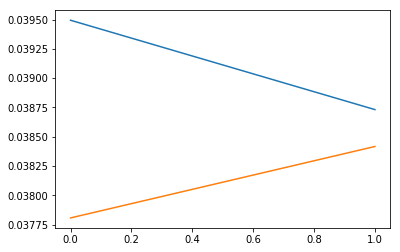

In [10]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
#plt.plot (hist.history['RocAus'])

In [12]:
y_pred = model.predict(X_te, batch_size=128)
submission = pd.read_csv('./sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission11.csv', index=False)

In [17]:
model.save('my_model11.h5') 

In [11]:
from keras.models import load_model
model = load_model('my_model11.h5') 